In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


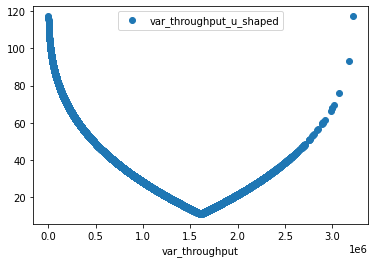

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [7]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [9]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [10]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [11]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [12]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [14]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=50,
                  validation_data=(X_test, y_test_rapport), 
#                   callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 47ms/step - loss: 0.6932 - accuracy: 0.2551 - f1_m: 0.1647 - recall_m: 0.1756 - precision_m: 0.1558 - val_loss: 0.6891 - val_accuracy: 0.8712 - val_f1_m: 0.9305 - val_recall_m: 1.0000 - val_precision_m: 0.8704
Epoch 2/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6933 - accuracy: 0.6903 - f1_m: 0.7150 - recall_m: 0.7658 - precision_m: 0.7638 - val_loss: 0.6942 - val_accuracy: 0.2995 - val_f1_m: 0.3599 - val_recall_m: 0.2275 - val_precision_m: 0.8797
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6928 - accuracy: 0.4352 - f1_m: 0.4360 - recall_m: 0.4094 - precision_m: 0.8136 - val_loss: 0.6776 - val_accuracy: 0.8382 - val_f1_m: 0.9108 - val_recall_m: 0.9572 - val_precision_m: 0.8693
Epoch 4/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6869 - accuracy: 0.5189 - f1_m: 0.6240 - recall_m: 0.5098 - precision_m: 0.8903 - val_loss: 0.6295 - val_accuracy: 0.5712 - val_f1

Epoch 32/50
72/72 [==============================] - 3s 45ms/step - loss: 0.5227 - accuracy: 0.7052 - f1_m: 0.7965 - recall_m: 0.6874 - precision_m: 0.9581 - val_loss: 0.5315 - val_accuracy: 0.7564 - val_f1_m: 0.8574 - val_recall_m: 0.8462 - val_precision_m: 0.8697
Epoch 33/50
72/72 [==============================] - 3s 37ms/step - loss: 0.5118 - accuracy: 0.7174 - f1_m: 0.8073 - recall_m: 0.7064 - precision_m: 0.9551 - val_loss: 0.9569 - val_accuracy: 0.4151 - val_f1_m: 0.5314 - val_recall_m: 0.3840 - val_precision_m: 0.8686
Epoch 34/50
72/72 [==============================] - 3s 40ms/step - loss: 0.5062 - accuracy: 0.7190 - f1_m: 0.8106 - recall_m: 0.7069 - precision_m: 0.9612 - val_loss: 0.6060 - val_accuracy: 0.6961 - val_f1_m: 0.8138 - val_recall_m: 0.7674 - val_precision_m: 0.8670
Epoch 35/50
72/72 [==============================] - 3s 40ms/step - loss: 0.4999 - accuracy: 0.7320 - f1_m: 0.8163 - recall_m: 0.7140 - precision_m: 0.9632 - val_loss: 0.6222 - val_accuracy: 0.6715 - va

In [15]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

(0.49625448028673835, 0.4935186317800676, 0.48095155664286604, None)

In [16]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=50,
                   validation_data=(X_test, y_test_gamemove), 
#                    callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 45ms/step - loss: 0.6936 - accuracy: 0.8059 - f1_m: 0.8273 - recall_m: 0.8611 - precision_m: 0.7964 - val_loss: 0.6944 - val_accuracy: 0.0624 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/50
72/72 [==============================] - 3s 38ms/step - loss: 0.6932 - accuracy: 0.1189 - f1_m: 0.0782 - recall_m: 0.0619 - precision_m: 0.1714 - val_loss: 0.6894 - val_accuracy: 0.9376 - val_f1_m: 0.9675 - val_recall_m: 1.0000 - val_precision_m: 0.9372
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6933 - accuracy: 0.6712 - f1_m: 0.6680 - recall_m: 0.6887 - precision_m: 0.6599 - val_loss: 0.6685 - val_accuracy: 0.9376 - val_f1_m: 0.9675 - val_recall_m: 1.0000 - val_precision_m: 0.9372
Epoch 4/50
72/72 [==============================] - 3s 38ms/step - loss: 0.6919 - accuracy: 0.5779 - f1_m: 0.5890 - recall_m: 0.5929 - precision_m: 0.6397 - val_loss: 0.6217 - val_accuracy: 0.9

Epoch 32/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4653 - accuracy: 0.7412 - f1_m: 0.8369 - recall_m: 0.7371 - precision_m: 0.9852 - val_loss: 0.9225 - val_accuracy: 0.5255 - val_f1_m: 0.6731 - val_recall_m: 0.5254 - val_precision_m: 0.9413
Epoch 33/50
72/72 [==============================] - 3s 37ms/step - loss: 0.4591 - accuracy: 0.7400 - f1_m: 0.8334 - recall_m: 0.7314 - precision_m: 0.9858 - val_loss: 0.4748 - val_accuracy: 0.7691 - val_f1_m: 0.8672 - val_recall_m: 0.8072 - val_precision_m: 0.9380
Epoch 34/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4456 - accuracy: 0.7549 - f1_m: 0.8429 - recall_m: 0.7434 - precision_m: 0.9867 - val_loss: 0.7696 - val_accuracy: 0.5528 - val_f1_m: 0.6981 - val_recall_m: 0.5548 - val_precision_m: 0.9448
Epoch 35/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4480 - accuracy: 0.7462 - f1_m: 0.8394 - recall_m: 0.7411 - precision_m: 0.9868 - val_loss: 0.9919 - val_accuracy: 0.4894 - va

In [17]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.5080762000339232, 0.5301971302486589, 0.45659878470390347, None)

In [18]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_reasoning), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 4s 54ms/step - loss: 0.6932 - accuracy: 0.2694 - f1_m: 0.1517 - recall_m: 0.1665 - precision_m: 0.1396 - val_loss: 0.6871 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 2/50
72/72 [==============================] - 3s 46ms/step - loss: 0.6933 - accuracy: 0.7013 - f1_m: 0.7480 - recall_m: 0.8102 - precision_m: 0.7409 - val_loss: 0.6889 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 3/50
72/72 [==============================] - 3s 42ms/step - loss: 0.6934 - accuracy: 0.5486 - f1_m: 0.5406 - recall_m: 0.5785 - precision_m: 0.6066 - val_loss: 0.6836 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 4/50
72/72 [==============================] - 3s 40ms/step - loss: 0.6919 - accuracy: 0.7782 - f1_m: 0.8537 - recall_m: 0.9009 - precision_m: 0.8258 - val_loss: 0.6833 - val_accuracy: 0.6922 - val_f1

Epoch 32/50
72/72 [==============================] - 3s 37ms/step - loss: 0.4796 - accuracy: 0.7480 - f1_m: 0.8262 - recall_m: 0.7317 - precision_m: 0.9548 - val_loss: 0.7092 - val_accuracy: 0.6328 - val_f1_m: 0.7559 - val_recall_m: 0.6976 - val_precision_m: 0.8274
Epoch 33/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4722 - accuracy: 0.7565 - f1_m: 0.8340 - recall_m: 0.7470 - precision_m: 0.9516 - val_loss: 0.8884 - val_accuracy: 0.4815 - val_f1_m: 0.5948 - val_recall_m: 0.4665 - val_precision_m: 0.8285
Epoch 34/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4961 - accuracy: 0.7411 - f1_m: 0.8185 - recall_m: 0.7268 - precision_m: 0.9491 - val_loss: 0.6928 - val_accuracy: 0.6495 - val_f1_m: 0.7693 - val_recall_m: 0.7172 - val_precision_m: 0.8320
Epoch 35/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4606 - accuracy: 0.7613 - f1_m: 0.8399 - recall_m: 0.7526 - precision_m: 0.9549 - val_loss: 0.7943 - val_accuracy: 0.6073 - va

In [19]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.5152320735087327, 0.5222242038721439, 0.5060049534044161, None)

In [20]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_share_information), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 45ms/step - loss: 0.6932 - accuracy: 0.6827 - f1_m: 0.7062 - recall_m: 0.7765 - precision_m: 0.6594 - val_loss: 0.6917 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 1.0000 - val_precision_m: 0.8436
Epoch 2/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6933 - accuracy: 0.6965 - f1_m: 0.7396 - recall_m: 0.7985 - precision_m: 0.7420 - val_loss: 0.6886 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 1.0000 - val_precision_m: 0.8436
Epoch 3/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6930 - accuracy: 0.7662 - f1_m: 0.8517 - recall_m: 0.8906 - precision_m: 0.8460 - val_loss: 0.6893 - val_accuracy: 0.7502 - val_f1_m: 0.8518 - val_recall_m: 0.8582 - val_precision_m: 0.8477
Epoch 4/50
72/72 [==============================] - 3s 39ms/step - loss: 0.6914 - accuracy: 0.6793 - f1_m: 0.7900 - recall_m: 0.7432 - precision_m: 0.8620 - val_loss: 0.6706 - val_accuracy: 0.5616 - val_f1

Epoch 32/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4747 - accuracy: 0.6906 - f1_m: 0.7747 - recall_m: 0.6515 - precision_m: 0.9695 - val_loss: 0.6783 - val_accuracy: 0.6522 - val_f1_m: 0.7751 - val_recall_m: 0.7144 - val_precision_m: 0.8500
Epoch 33/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4619 - accuracy: 0.7033 - f1_m: 0.7833 - recall_m: 0.6628 - precision_m: 0.9705 - val_loss: 0.6990 - val_accuracy: 0.6284 - val_f1_m: 0.7552 - val_recall_m: 0.6828 - val_precision_m: 0.8479
Epoch 34/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4593 - accuracy: 0.7058 - f1_m: 0.7932 - recall_m: 0.6769 - precision_m: 0.9687 - val_loss: 0.7485 - val_accuracy: 0.6236 - val_f1_m: 0.7510 - val_recall_m: 0.6766 - val_precision_m: 0.8473
Epoch 35/50
72/72 [==============================] - 3s 38ms/step - loss: 0.4487 - accuracy: 0.7146 - f1_m: 0.8008 - recall_m: 0.6855 - precision_m: 0.9713 - val_loss: 0.6859 - val_accuracy: 0.6750 - va

In [21]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.5048475307745598, 0.5077109816384181, 0.4913954032885029, None)

In [22]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=50,
                    validation_data=(X_test, y_test_deception), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/50
285/285 [==============================] - 8s 28ms/step - loss: 0.6933 - accuracy: 0.7661 - f1_m: 0.7787 - recall_m: 0.7997 - precision_m: 0.7688 - val_loss: 0.6926 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/50
285/285 [==============================] - 7s 26ms/step - loss: 0.6935 - accuracy: 0.9476 - f1_m: 0.9725 - recall_m: 0.9966 - precision_m: 0.9512 - val_loss: 0.6848 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 3/50
285/285 [==============================] - 7s 26ms/step - loss: 0.6925 - accuracy: 0.9259 - f1_m: 0.9594 - recall_m: 0.9702 - precision_m: 0.9534 - val_loss: 0.6316 - val_accuracy: 0.9485 - val_f1_m: 0.9736 - val_recall_m: 0.9977 - val_precision_m: 0.9513
Epoch 4/50
285/285 [==============================] - 7s 25ms/step - loss: 0.6870 - accuracy: 0.7590 - f1_m: 0.8383 - recall_m: 0.7789 - precision_m: 0.9638 - val_loss: 0.5686 - val_accuracy: 0.7801 

Epoch 32/50
285/285 [==============================] - 7s 26ms/step - loss: 0.2663 - accuracy: 0.8821 - f1_m: 0.9324 - recall_m: 0.8814 - precision_m: 0.9941 - val_loss: 0.6896 - val_accuracy: 0.7172 - val_f1_m: 0.8283 - val_recall_m: 0.7385 - val_precision_m: 0.9507
Epoch 33/50
285/285 [==============================] - 7s 26ms/step - loss: 0.2534 - accuracy: 0.8866 - f1_m: 0.9354 - recall_m: 0.8856 - precision_m: 0.9950 - val_loss: 0.7930 - val_accuracy: 0.6935 - val_f1_m: 0.8119 - val_recall_m: 0.7125 - val_precision_m: 0.9519
Epoch 34/50
285/285 [==============================] - 7s 26ms/step - loss: 0.2441 - accuracy: 0.8906 - f1_m: 0.9380 - recall_m: 0.8899 - precision_m: 0.9953 - val_loss: 0.7597 - val_accuracy: 0.7089 - val_f1_m: 0.8222 - val_recall_m: 0.7285 - val_precision_m: 0.9528
Epoch 35/50
285/285 [==============================] - 7s 26ms/step - loss: 0.2270 - accuracy: 0.8989 - f1_m: 0.9423 - recall_m: 0.8970 - precision_m: 0.9959 - val_loss: 0.9060 - val_accuracy: 0.6

In [23]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.5013129386274787, 0.5027628188185542, 0.4953223163070199, None)

In [24]:
# deception_pred_test

In [25]:
# unique, counts = np.unique(deception_pred_test_round, return_counts=True)

In [26]:
# print(unique, counts)

In [27]:
# deception_model.history.history['val_f1_m']

### One hot encodings

In [28]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [29]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [30]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6986 - acc: 0.7646 - f1_m: 0.8638 - precision_m: 0.9505 - recall_m: 0.7940 - val_loss: 0.6623 - val_acc: 0.7036 - val_

143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.8480 - f1_m: 0.9170 - precision_m: 0.9519 - recall_m: 0.8859 - val_loss: 0.6964 - val_acc: 0.8298 - val_f1_m: 0.9055 - val_precision_m: 0.9497 - val_recall_m: 0.8662
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.8671 - f1_m: 0.9284 - precision_m: 0.9524 - recall_m: 0.9067 - val_loss: 0.6941 - val_acc: 0.8355 - val_f1_m: 0.9090 - val_precision_m: 0.9500 - val_recall_m: 0.8721
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.8500 - f1_m: 0.9183 - precision_m: 0.9522 - recall_m: 0.8882 - val_loss: 0.6961 - val_acc: 0.8237 - val_f1_m: 0.9017 - val_precision_m: 0.9499 - val_recall_m: 0.8589
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.8512 - f1_m: 0.9189 - precision_m: 0.9522 - recall_m: 0.8890 - val_loss: 0.6939 - val_acc: 0.8399 - val_f1_m: 0.9116 - val_precision_m: 0.9503 - val_r

In [31]:
joint_predict = joint_full_model.predict(pred_test_df_full)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5004262788365095, 0.5009828862164662, 0.49192217791832804, None)

In [32]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 280 1994]


In [33]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6968 - acc: 0.2819 - f1_m: 0.2966 - precision_m: 0.5110 - recall_m: 0.2206 - val_loss: 0.6939 - val_acc: 0.6412 - val_f1

143/143 [==============================] - 0s 3ms/step - loss: 0.6616 - acc: 0.7445 - f1_m: 0.8433 - precision_m: 0.8924 - recall_m: 0.8017 - val_loss: 0.7080 - val_acc: 0.6777 - val_f1_m: 0.7998 - val_precision_m: 0.8686 - val_recall_m: 0.7428
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6601 - acc: 0.7377 - f1_m: 0.8380 - precision_m: 0.8930 - recall_m: 0.7917 - val_loss: 0.7079 - val_acc: 0.6829 - val_f1_m: 0.8035 - val_precision_m: 0.8694 - val_recall_m: 0.7488
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6587 - acc: 0.7491 - f1_m: 0.8453 - precision_m: 0.8930 - recall_m: 0.8052 - val_loss: 0.7072 - val_acc: 0.6843 - val_f1_m: 0.8048 - val_precision_m: 0.8682 - val_recall_m: 0.7519
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6575 - acc: 0.7571 - f1_m: 0.8511 - precision_m: 0.8911 - recall_m: 0.8173 - val_loss: 0.7108 - val_acc: 0.6799 - val_f1_m: 0.8010 - val_precision_m: 0.8677 - val_r

In [34]:
joint_predict = joint_full_model.predict(pred_test_df)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.49524272590014584, 0.4919930465704052, 0.4817321178120617, None)

In [35]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 575 1699]


## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [36]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [37]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [38]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.3654 - f1_m: 0.3628 - precision_m: 0.8122 - recall_m: 0.3584 - val_loss: 0.6925 

143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.8994 - f1_m: 0.9203 - precision_m: 0.9046 - recall_m: 0.9442 - val_loss: 0.6930 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.1833 - f1_m: 0.1529 - precision_m: 0.2539 - recall_m: 0.1559 - val_loss: 0.6924 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.2082 - f1_m: 0.1745 - precision_m: 0.2983 - recall_m: 0.1771 - val_loss: 0.6933 - val_acc: 0.0528 - val_f1_m: 0.0081 - val_precision_m: 0.2222 - val_recall_m: 0.0041
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.7240 - f1_m: 0.7364 - precision_m: 0.7578 - recall_m: 0.7560 - val_loss: 0.6922 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_r

In [39]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [40]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [41]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [42]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.2905 - f1_m: 0.2004 - precision_m: 0.1866 - recall_m: 0.2168 - val_loss: 0.6925 - 

Epoch 29/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.1396 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6934 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.7997 - f1_m: 0.8465 - precision_m: 0.7876 - recall_m: 0.9161 - val_loss: 0.6928 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.5164 - f1_m: 0.4837 - precision_m: 0.4494 - recall_m: 0.5245 - val_loss: 0.6937 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.5144 - f1_m: 0.4832 - precision_m: 0.4484 - recall_m: 0.5245 - val_loss: 0.6938 - val_acc: 0.1288 - va

In [43]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [44]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0.] [2274]


## WorkTime only

### Joint Model with one hot encoding 

In [45]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6934 - acc: 0.0535 - f1_m: 0.0085 - precision_m: 0.0826 - recall_m: 0.0051 - val_loss: 0.6947 - 

143/143 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.7256 - f1_m: 0.7851 - precision_m: 0.9455 - recall_m: 0.7461 - val_loss: 0.6899 - val_acc: 0.2397 - val_f1_m: 0.3404 - val_precision_m: 0.9571 - val_recall_m: 0.2093
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6919 - acc: 0.1269 - f1_m: 0.1513 - precision_m: 0.9394 - recall_m: 0.0861 - val_loss: 0.6921 - val_acc: 0.1174 - val_f1_m: 0.1373 - val_precision_m: 0.9571 - val_recall_m: 0.0748
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.2271 - f1_m: 0.2980 - precision_m: 0.9542 - recall_m: 0.2028 - val_loss: 0.6884 - val_acc: 0.8619 - val_f1_m: 0.9244 - val_precision_m: 0.9525 - val_recall_m: 0.8992
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6918 - acc: 0.1182 - f1_m: 0.1308 - precision_m: 0.9250 - recall_m: 0.0761 - val_loss: 0.6928 - val_acc: 0.1240 - val_f1_m: 0.1490 - val_precision_m: 0.9595 - val_r

In [46]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.503398838215301, 0.5054513017047707, 0.12308192659129628, None)

In [47]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2088  186]


In [48]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.7370 - f1_m: 0.8093 - precision_m: 0.8653 - recall_m: 0.8320 - val_loss: 0.6897 - va

143/143 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.4063 - f1_m: 0.4269 - precision_m: 0.8834 - recall_m: 0.3682 - val_loss: 0.6910 - val_acc: 0.6363 - val_f1_m: 0.7594 - val_precision_m: 0.8846 - val_recall_m: 0.6677
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.2996 - f1_m: 0.3286 - precision_m: 0.8945 - recall_m: 0.2136 - val_loss: 0.6913 - val_acc: 0.5352 - val_f1_m: 0.6567 - val_precision_m: 0.9014 - val_recall_m: 0.5195
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.6986 - f1_m: 0.7932 - precision_m: 0.8773 - recall_m: 0.7667 - val_loss: 0.6904 - val_acc: 0.6438 - val_f1_m: 0.7658 - val_precision_m: 0.8843 - val_recall_m: 0.6776
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6926 - acc: 0.4830 - f1_m: 0.5741 - precision_m: 0.8874 - recall_m: 0.4533 - val_loss: 0.6968 - val_acc: 0.2669 - val_f1_m: 0.2982 - val_precision_m: 0.8943 - val_r

In [49]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5129522411953041, 0.5167271674766941, 0.26530386789587695, None)

In [50]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1874  400]


## PC Agreement only

### Joint Model with one hot encoding 

In [51]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.1671 - f1_m: 0.1462 - precision_m: 0.1659 - recall_m: 0.1311 - val_loss: 0.695

Epoch 28/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.9017 - f1_m: 0.9481 - precision_m: 0.9516 - recall_m: 0.9457 - val_loss: 0.6921 - val_acc: 0.8685 - val_f1_m: 0.9287 - val_precision_m: 0.9508 - val_recall_m: 0.9084
Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8658 - f1_m: 0.9276 - precision_m: 0.9512 - recall_m: 0.9065 - val_loss: 0.6915 - val_acc: 0.8755 - val_f1_m: 0.9327 - val_precision_m: 0.9512 - val_recall_m: 0.9157
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6931 - acc: 0.9032 - f1_m: 0.9490 - precision_m: 0.9515 - recall_m: 0.9473 - val_loss: 0.6907 - val_acc: 0.8883 - val_f1_m: 0.9399 - val_precision_m: 0.9518 - val_recall_m: 0.9289
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6930 - acc: 0.9009 - f1_m: 0.9477 - precision_m: 0.9514 - recall_m: 0.9447 - val_loss: 0.6912 - val_acc: 0.8892 - val_f1_m: 0.9404 - val_precision_m: 0.

In [52]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5086271567891973, 0.5039625589861362, 0.49705072543272577, None)

In [53]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 124 2150]


In [54]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [55]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6920 - acc: 0.5725 - f1_m: 0.6309 - precision_m: 0.8629 - recall_m: 0.5754 - val_loss: 0.6840 

143/143 [==============================] - 1s 4ms/step - loss: 0.5792 - acc: 0.6378 - f1_m: 0.7436 - precision_m: 0.9474 - recall_m: 0.6147 - val_loss: 0.6139 - val_acc: 0.5695 - val_f1_m: 0.6829 - val_precision_m: 0.9378 - val_recall_m: 0.5384
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.5791 - acc: 0.6408 - f1_m: 0.7444 - precision_m: 0.9454 - recall_m: 0.6169 - val_loss: 0.6266 - val_acc: 0.5554 - val_f1_m: 0.6684 - val_precision_m: 0.9407 - val_recall_m: 0.5200
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.5792 - acc: 0.6225 - f1_m: 0.7266 - precision_m: 0.9492 - recall_m: 0.5916 - val_loss: 0.6195 - val_acc: 0.5629 - val_f1_m: 0.6759 - val_precision_m: 0.9393 - val_recall_m: 0.5296
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.5790 - acc: 0.6280 - f1_m: 0.7350 - precision_m: 0.9493 - recall_m: 0.6032 - val_loss: 0.6141 - val_acc: 0.5708 - val_f1_m: 0.6841 - val_precision_m: 0.9380 - val_r

In [56]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5436406252221259, 0.5846213085748053, 0.528284811140698, None)

In [57]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 728 1546]


## Text Length only

### Joint Model with one hot encoding 

In [58]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.1275 - f1_m: 0.1394 - precision_m: 0.8989 - recall_m: 0.0880 - val_loss: 0.6929

143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.4767 - f1_m: 0.4780 - precision_m: 0.8058 - recall_m: 0.4798 - val_loss: 0.6920 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6913 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6901 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.9509 - f1_m: 0.9748 - precision_m: 0.9513 - recall_m: 1.0000 - val_loss: 0.6916 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_r

In [59]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [60]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [61]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6920 - acc: 0.6013 - f1_m: 0.7035 - precision_m: 0.8953 - recall_m: 0.6182 - val_loss: 0.6853 -

143/143 [==============================] - 0s 3ms/step - loss: 0.6480 - acc: 0.5262 - f1_m: 0.6323 - precision_m: 0.9343 - recall_m: 0.4818 - val_loss: 0.6615 - val_acc: 0.5018 - val_f1_m: 0.6202 - val_precision_m: 0.9123 - val_recall_m: 0.4725
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6477 - acc: 0.5411 - f1_m: 0.6520 - precision_m: 0.9327 - recall_m: 0.5047 - val_loss: 0.6660 - val_acc: 0.4930 - val_f1_m: 0.6096 - val_precision_m: 0.9128 - val_recall_m: 0.4605
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6474 - acc: 0.5364 - f1_m: 0.6464 - precision_m: 0.9356 - recall_m: 0.4984 - val_loss: 0.6493 - val_acc: 0.5193 - val_f1_m: 0.6399 - val_precision_m: 0.9113 - val_recall_m: 0.4955
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6472 - acc: 0.5509 - f1_m: 0.6595 - precision_m: 0.9332 - recall_m: 0.5138 - val_loss: 0.6682 - val_acc: 0.4899 - val_f1_m: 0.6062 - val_precision_m: 0.9130 - val_r

In [62]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5381740418245897, 0.5836211931437393, 0.4368249175041504, None)

In [63]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1283  991]


## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [64]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6940 - acc: 0.5653 - f1_m: 0.6893 - precision_m: 0.9560 - recall_m: 0.5731 - val_loss: 0.6

143/143 [==============================] - 1s 4ms/step - loss: 0.6904 - acc: 0.3171 - f1_m: 0.4471 - precision_m: 0.9541 - recall_m: 0.2956 - val_loss: 0.6881 - val_acc: 0.3329 - val_f1_m: 0.4722 - val_precision_m: 0.9496 - val_recall_m: 0.3167
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6902 - acc: 0.3178 - f1_m: 0.4487 - precision_m: 0.9555 - recall_m: 0.2964 - val_loss: 0.6871 - val_acc: 0.3676 - val_f1_m: 0.5125 - val_precision_m: 0.9544 - val_recall_m: 0.3528
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6902 - acc: 0.3291 - f1_m: 0.4610 - precision_m: 0.9575 - recall_m: 0.3083 - val_loss: 0.6843 - val_acc: 0.3874 - val_f1_m: 0.5372 - val_precision_m: 0.9490 - val_recall_m: 0.3771
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6901 - acc: 0.3518 - f1_m: 0.4906 - precision_m: 0.9560 - recall_m: 0.3335 - val_loss: 0.6893 - val_acc: 0.3289 - val_f1_m: 0.4671 - val_precision_m: 0.9508 - val_r

In [65]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.49884191614174084, 0.4946973701599049, 0.279438355766156, None)

In [66]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1566  708]


In [67]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [68]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6904 - acc: 0.7904 - f1_m: 0.8757 - precision_m: 0.8659 - recall_m: 0.8930 - val_loss: 0.678

143/143 [==============================] - 0s 3ms/step - loss: 0.6658 - acc: 0.4778 - f1_m: 0.5847 - precision_m: 0.9197 - recall_m: 0.4324 - val_loss: 0.6793 - val_acc: 0.4494 - val_f1_m: 0.5652 - val_precision_m: 0.8991 - val_recall_m: 0.4161
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6657 - acc: 0.4848 - f1_m: 0.5918 - precision_m: 0.9159 - recall_m: 0.4398 - val_loss: 0.6854 - val_acc: 0.4433 - val_f1_m: 0.5574 - val_precision_m: 0.9013 - val_recall_m: 0.4072
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6656 - acc: 0.4814 - f1_m: 0.5877 - precision_m: 0.9164 - recall_m: 0.4357 - val_loss: 0.6833 - val_acc: 0.4433 - val_f1_m: 0.5582 - val_precision_m: 0.8986 - val_recall_m: 0.4087
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6656 - acc: 0.4934 - f1_m: 0.6050 - precision_m: 0.9174 - recall_m: 0.4561 - val_loss: 0.6821 - val_acc: 0.4459 - val_f1_m: 0.5613 - val_precision_m: 0.8992 - val_r

In [69]:
joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5239812040194879, 0.5511109809400913, 0.40325054379836595, None)

In [70]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1373  901]
